## Locally Weighted Regression (LWR)

In [2]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from mixture_model import *
from plot_utils import *
from scipy.stats import norm as normal_dist

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Using LWR for the letter data

The letter data consists of two variables, $x_{1,t}$ and $x_{2,t}$ that moves for $T$ time steps. 

Without loss of generality, we assume that the movement begins at time $t=0$ and ends at time $t=1$. 

In this demo, we want to approximate the function $f(t)$:
$$f(t) = [x_{1,t},x_{2,t}]$$
using LWR. In other words, given the current time $t$ we want to predict the location of $[x_{1,t},x_{2,t}]$.

Since the problem is nonlinear, we also expand the input $t$ polynomially, i.e. instead of using $t$ as input, we use $[1, t, t^2]$. 

### Declare Variables 

In [6]:
n_states = 4 #number of LWR basis functions
poly_deg = 2 #Degree of the polynomial for the input
n_out = 2 #number of motion variables
n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations

t_in = np.linspace(0,1,n_data) #time along the trajectory

### Load Data 

Text(0,0.5,'x2')

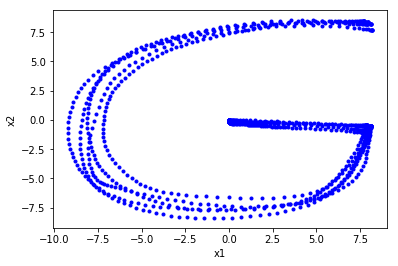

In [4]:
ROOT = '../python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[1:n_samples+1]

#construct the output Y by concatenating all demonstrations
data = data.transpose([0,2,1])
Y = np.concatenate(data,axis=0)

plt.plot(Y[:,0], Y[:,1],'.b')
plt.xlabel('x1')
plt.ylabel('x2')

#### Plot the data for each dimension against the time 

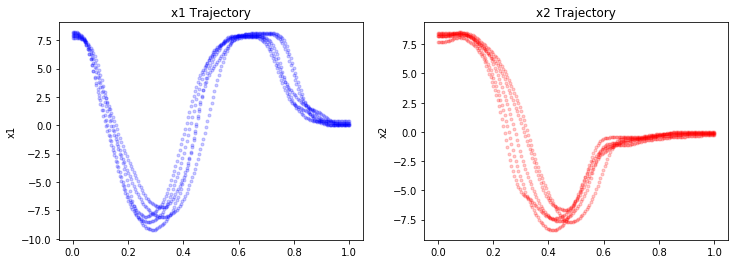

In [5]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,4)
ax[0].set_title('x1 Trajectory')
ax[0].set_ylabel('t')
ax[0].set_ylabel('x1')
ax[1].set_title('x2 Trajectory')
ax[1].set_ylabel('t')
ax[1].set_ylabel('x2')

for data_i in data:
    ax[0].plot(t_in, data_i[:,0],'.b',alpha=0.2)
    ax[1].plot(t_in, data_i[:,1],'.r',alpha=0.2)

### Define the radial basis functions for LWR

We need to choose:
- the number of basis functions
- the mean (center) and the variance (width)  of each basis function

Given the number of basis functions, we can distribute the mean uniformly along the input interval, and choose the width such that we have sufficient overlaps between the basis functions

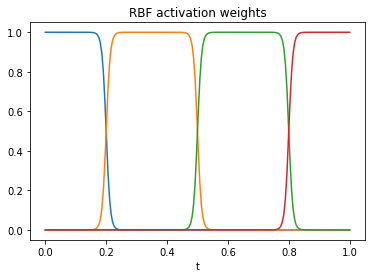

In [23]:
#define the separation time between each basis function
t_sep = np.linspace(-0.1,1.1,n_states+1)

#set the mean of the basis functions
mus = np.zeros(n_states)
for i in range(n_states):
    mus[i] = 0.5*(t_sep[i]+t_sep[i+1])

#set the width of the basis functions
sigmas = np.array([2e-3]*n_states)

#Compute the activation weights
# This is the weight of each basis function at a given time
H = np.zeros((n_states, n_data))
for i in range(n_states):
    H[i] = normal_dist(loc = mus[i], scale = np.sqrt(sigmas[i])).pdf(t_in)
H /= np.sum(H,axis=0) #normalizing the weights

#plot the radial basis functions
for i in range(n_states):
    plt.plot(t_in, H[i],'-')
plt.xlabel('t')
plt.title('RBF activation weights')    

#repeat Hn for n samples
Hn = np.tile(H,(1,n_samples)) 

### Compute LWR 

Given the input $X$, the output $Y$, and $K$ basis functions, LWR solves $K$ weighted least squares problem as follows:
$$ A_k = \underset{A}{\operatorname{argmin}} ||XA-Y ||^2_{W_k}$$

where $W_k$ is normally a diagonal matrix that weigh each input in $X$ according to the $k_{th}$ RBF basis function.

Having obtained $\{A_k\}_{k=1}^{K}$, given the test input $X_{test}$, we can compute the prediction by calculating the prediction according to each $A_k$, and do a weighted sum of them, the weight is computed by the corresponding RBF basis function. 

$$Y_{test} = \sum_{k=1}^{K} W_kX_{test}A_k$$


#### Construct the polynomial input of degree=poly_deg

In [25]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=poly_deg)
Xr = poly.fit_transform(t_in[:,None]) #input for LWR
X = np.tile(Xr,(n_samples,1)) #replicating for n samples

#### Calculate the LWR Parameters

In [19]:
#calculate a set of parameters for each state
As = []
for i in range(n_states):
    W = np.diag(Hn[i])
    A = dot(inv(dot(X.T,dot(W,X))+np.eye(poly_deg+1)*1e-5),dot(X.T, dot(W,Y)))
    As.append(A)

#### Calculate the prediction 

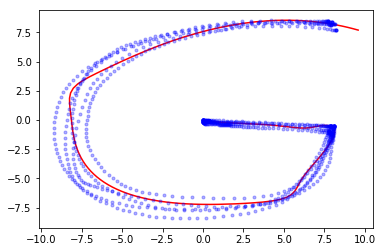

In [20]:
Y_preds = []
for i in range(n_states):
    Y_pred = np.multiply(H[i][:,None], dot(Xr,As[i]))
    Y_preds.append(Y_pred)
    
Y_preds = np.array(Y_preds)
Y_preds = np.sum(Y_preds, axis=0)

plt.plot(Y_preds[:,0], Y_preds[:,1],'-r', alpha=1)
plt.plot(Y[:,0], Y[:,1],'.b', alpha=0.3)

#### Visualise the prediction for each dimension 

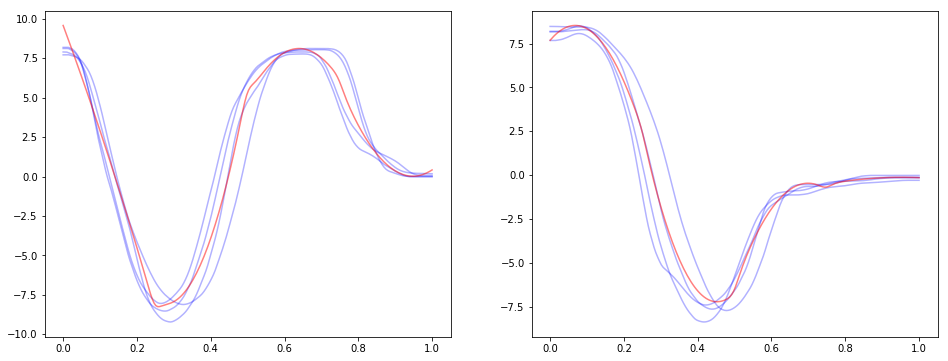

In [26]:
plt.figure(figsize=(16, 6))
for i in range(1,n_samples):
    plt.subplot(1,2,1)
    plt.plot(t_in, Y[i*n_data:(i+1)*n_data,0],'-b', alpha=0.3)
    plt.subplot(1,2,2)
    plt.plot(t_in, Y[i*n_data:(i+1)*n_data,1],'-b',alpha=0.3)

plt.subplot(1,2,1)    
plt.plot(t_in, Y_preds[:,0], '-r', alpha=0.5)
plt.subplot(1,2,2)
plt.plot(t_in, Y_preds[:,1], '-r', alpha=0.5)
